# Import Required Classes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import json
import sys
sys.path.append('../src')

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/notebooks


In [21]:
from XGBoostBaselineClassifier import XGBoostBaselineClassifier
from XGBoostTuner import XGBoostTunerCV
from MetricsCore import MetricsCalculator
from DiskIO import DiskIO

# Run Baseline XGBoost Classifier

In [4]:
baseline = XGBoostBaselineClassifier()
baseline.load_and_prepare_data()

In [5]:
baseline.train()

Classification Report:
Accuracy: 98.23%
Recall: 97.7%
Specificity: 99.62%
PPV: 98.04%
NPV: 99.63%
F1: 97.86%


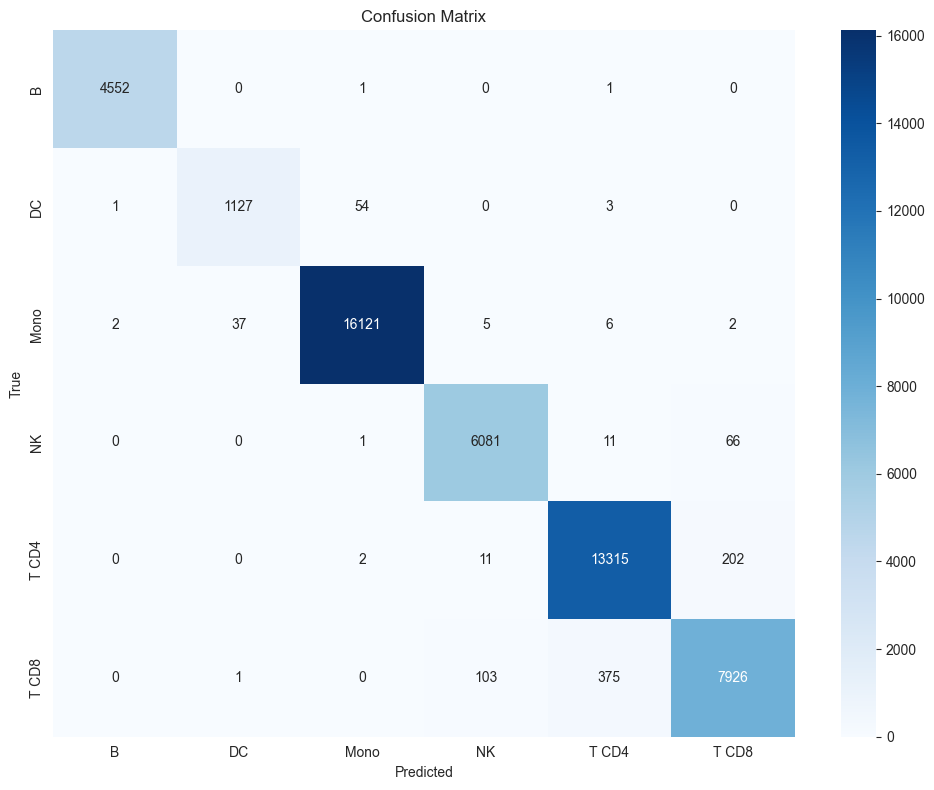

In [6]:
# Unpack the evaluation results: (train_results, test_results)
report, cm, stats = baseline.evaluate()

print("Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
baseline.plot_confusion_matrix(cm)

In [7]:
# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.999,1.000,0.999,4554.000
DC,0.967,0.951,0.959,1185.000
Mono,0.996,0.997,0.997,16173.000
NK,0.981,0.987,0.984,6159.000
T CD4,0.971,0.984,0.978,13530.000
T CD8,0.967,0.943,0.955,8405.000
macro avg,0.980,0.977,0.979,50006.000
weighted avg,0.982,0.982,0.982,50006.000
accuracy,NaN,NaN,NaN,0.982


In [8]:
model_name = 'baseline'
baseline.save_model(pipeline=baseline.pipeline, label_encoder=baseline.label_encoder)

# Optuna Tuning for XGBoost - Nested CV

In [9]:
# Initialize tuner
tuner = XGBoostTunerCV(n_trials=30)

In [10]:
# # Find optimal hyperparameters with Optuna
# tuner.tune_hyperparameters()

[I 2025-07-05 02:50:39,035] A new study created in memory with name: no-name-43fbdcba-1f4e-47b2-aa3d-ade627b8f168
[I 2025-07-05 02:53:06,379] Trial 0 finished with value: 0.9824127975564659 and parameters: {'n_estimators': 134, 'max_depth': 6, 'learning_rate': 0.1881027566867216, 'min_child_weight': 1, 'gamma': 0.0185024891042449, 'subsample': 0.6708731853032691, 'colsample_bytree': 0.8810466668862986, 'reg_alpha': 0.5226884719012855, 'reg_lambda': 7.376973952389211}. Best is trial 0 with value: 0.9824127975564659.
[I 2025-07-05 02:53:55,720] Trial 1 finished with value: 0.981520617552995 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.16385880530414457, 'min_child_weight': 2, 'gamma': 0.9014214075460274, 'subsample': 0.8826865502582406, 'colsample_bytree': 0.7288709962988288, 'reg_alpha': 0.7539286396891056, 'reg_lambda': 9.493456928698272}. Best is trial 0 with value: 0.9824127975564659.
[I 2025-07-05 02:54:50,144] Trial 2 finished with value: 0.97108509860988

[Nested CV] Outer F1 Scores: [0.9833105050272324, 0.9825117208108695, 0.9833813192925305, 0.9839199777041006, 0.9830334877277723]
[Nested CV] Mean Outer F1 Score: 0.9832


In [11]:
# # Print best parameters
# print("Best Parameters Found:")
# print(tuner.best_params)

# # Save best parameters to a JSON file to avoid running the tuning again
# with open("xgboost_best_params.json", "w") as f:
#     json.dump(tuner.best_params, f, indent=4)

Best Parameters Found:
{'n_estimators': 130, 'max_depth': 7, 'learning_rate': 0.16766749905864017, 'min_child_weight': 2, 'gamma': 0.8350535604604887, 'subsample': 0.9485197249922602, 'colsample_bytree': 0.6051782485625062, 'reg_alpha': 0.5811430358719555, 'reg_lambda': 8.474415573882194}


In [10]:
# Load the saved parameters
with open("xgboost_best_params.json", "r") as f:
    best_params = json.load(f)

# Set the loaded parameters
tuner.best_params = best_params  

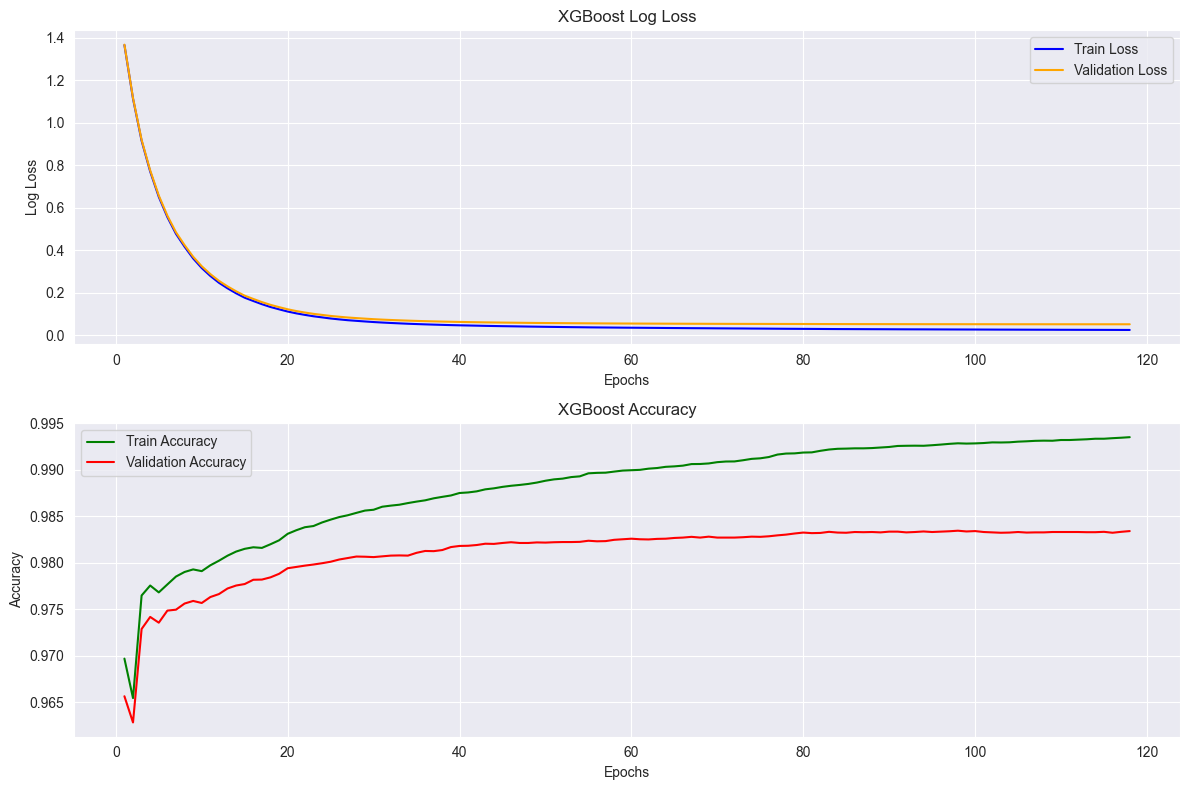

In [11]:
# Train the model on the 67% of the Hao dataset (training set) and validate on 33% and plot the Learning Curves to check overfitting
tuner.train_internal_split()
tuner.plot_learning_curve()

In [12]:
# Train on full Hao datasets and save final model
tuner.train_and_save_final_model_on_full_data()

In [13]:
# Evaluate the trained model on the external Kotliarov dataset
report, cm, stats = tuner.evaluate_on_external_testset()

In [14]:
# Print results

# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.967,0.981,0.974,5828.000
DC,0.961,0.647,0.773,646.000
Mono,0.855,0.997,0.921,7851.000
NK,0.880,0.973,0.924,4722.000
T CD4,0.917,0.918,0.917,20119.000
T CD8,0.932,0.772,0.844,9780.000
macro avg,0.919,0.881,0.892,48946.000
weighted avg,0.913,0.911,0.909,48946.000
accuracy,NaN,NaN,NaN,0.911


Tuned Model - Classification Report:
Accuracy: 91.05%
Recall: 88.12%
Specificity: 97.95%
PPV: 91.87%
NPV: 97.95%
F1: 89.23%


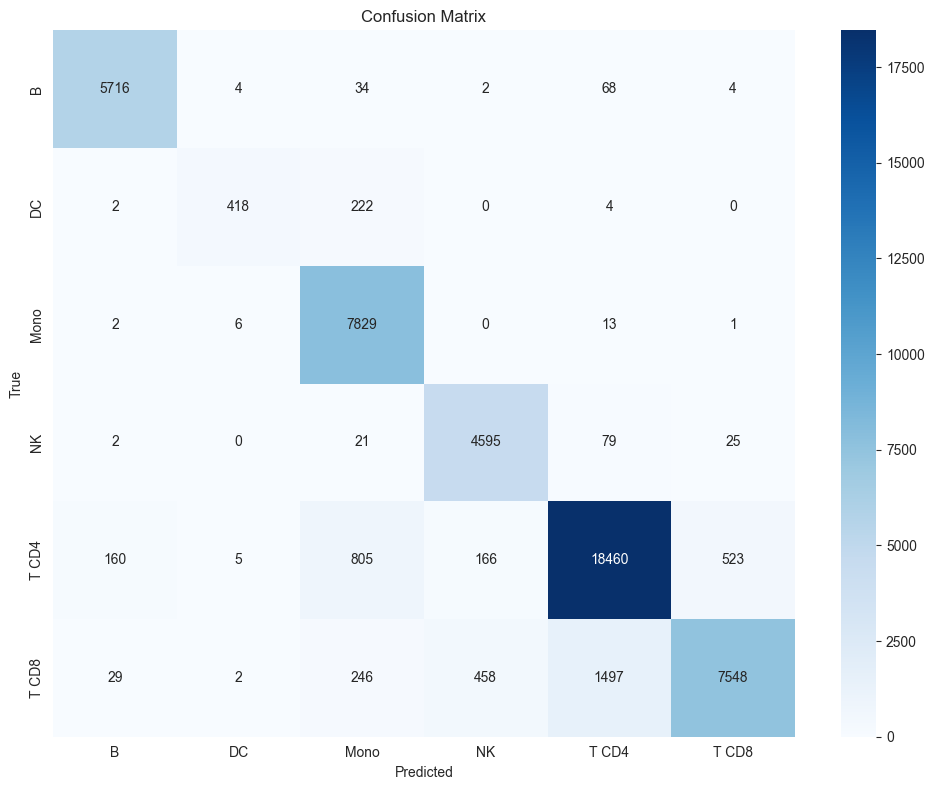

In [ ]:
# Print stats
print("XGBoost - Tuned Model - Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
tuner.plot_confusion_matrix(cm)

# Baseline vs Tuned

In [16]:
# Load training set to get feature names in correct order
hao = pd.read_csv("../data/hao.csv", index_col=0)
expected_features = hao.drop(columns=["label"]).columns

In [17]:
# Load Kotliarov test data (same format as hao.csv)
kotliarov = pd.read_csv("../data/kotliarov.csv", index_col=0)
X_kot = kotliarov.drop(columns=["label"])
y_kot = kotliarov["label"]

# Align Kotliarov features to match training features
X_kot_aligned = X_kot[expected_features]

In [22]:
def get_pipeline(loaded_obj):
    """Extracts pipeline from loaded object (handles both tuple and non-tuple cases)"""
    return loaded_obj[0] if isinstance(loaded_obj, tuple) else loaded_obj

In [24]:
io = DiskIO("../models")

baseline_model = get_pipeline(io.load("XGBoost", "baseline"))
tuned_model = get_pipeline(io.load("XGBoost", "final")) 
label_encoder = io.load("label_encoder_final")

In [19]:
# Get the list of class labels the encoder was originally trained on
known_labels = label_encoder.classes_

# Create a boolean mask to keep only samples with labels the encoder recognizes
# This is necessary to avoid transforming labels that were not seen during training (would raise an error)
valid_mask = y_kot.isin(known_labels)

# Align test features with training feature order and keep only valid rows
X_kot_aligned = X_kot[valid_mask][expected_features]

# Filter the test labels to include only valid rows (i.e., rows with known labels)
y_kot_filtered = y_kot[valid_mask]

# Transform the filtered string labels into numerical form using the trained encoder
y_kot_encoded = label_encoder.transform(y_kot_filtered)

---

In [26]:
def calculate_bootstrap_ci(pipeline, X, y, metrics=None, n_bootstrap=1000, random_state=None):
    """Standalone bootstrap CI calculation for any model"""
    metrics_calc = MetricsCalculator(metrics=metrics or ['Accuracy', 'Recall', 'Specificity', 'PPV', 'NPV', 'F1'])
    metric_names = metrics_calc.METRICS
    metrics_dict = {name: [] for name in metric_names}
    
    rng = np.random.RandomState(random_state)
    
    for _ in range(n_bootstrap):
        indices = rng.choice(len(y), size=len(y), replace=True)
        X_bs = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
        y_bs = y[indices]

        metrics = metrics_calc.compute(y_bs, pipeline.predict(X_bs))
        
        for name, value in metrics.items():
            metrics_dict[name].append(value / 100)  # Convert percentage to ratio
    
    ci = {}
    for metric, values in metrics_dict.items():
        ci[metric] = {
            'mean': np.mean(values),
            'std_error': np.std(values, ddof=1),  # SEM
            'lower': np.percentile(values, 2.5),
            'upper': np.percentile(values, 97.5)
        }
    
    return ci

---

In [27]:
# Initialize metrics calculator
metrics_calculator = MetricsCalculator()

# Get point estimates (non-bootstrap)
baseline_metrics = metrics_calculator.compute_from_model(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_metrics = metrics_calculator.compute_from_model(tuned_model, X_kot_aligned, y_kot_encoded)  

# Get bootstrap distributions (for CIs)
baseline_ci = calculate_bootstrap_ci(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_ci = calculate_bootstrap_ci(tuned_model, X_kot_aligned, y_kot_encoded)

In [28]:
# Formatted DataFrame

metrics = ['Accuracy', 'Recall', 'Specificity', 'PPV', 'NPV', 'F1']

# Create display-friendly DataFrame
results_df = pd.DataFrame([
    {
        'Metric': metric,
        'Baseline': f"{baseline_ci[metric]['mean']*100:.2f} ± {baseline_ci[metric]['std_error']*100:.2f}",
        'Baseline CI': f"[{baseline_ci[metric]['lower']*100:.2f}, {baseline_ci[metric]['upper']*100:.2f}]",
        'Tuned': f"{tuned_ci[metric]['mean']*100:.2f} ± {tuned_ci[metric]['std_error']*100:.2f}",
        'Tuned CI': f"[{tuned_ci[metric]['lower']*100:.2f}, {tuned_ci[metric]['upper']*100:.2f}]"
    } 
    for metric in metrics
])

print("\nModel Performance Comparison with Confidence Intervals")
print("="*85)
display(results_df)


Model Performance Comparison with Confidence Intervals


,Metric,Baseline,Baseline CI,Tuned,Tuned CI
0,Accuracy,90.49 ± 0.13,"[90.24, 90.77]",91.05 ± 0.13,"[90.80, 91.33]"
1,Recall,88.22 ± 0.32,"[87.63, 88.85]",88.11 ± 0.34,"[87.43, 88.76]"
2,Specificity,97.83 ± 0.03,"[97.78, 97.90]",97.95 ± 0.03,"[97.89, 98.01]"
3,PPV,91.53 ± 0.21,"[91.12, 91.90]",91.86 ± 0.20,"[91.47, 92.24]"
4,NPV,97.81 ± 0.03,"[97.75, 97.87]",97.95 ± 0.03,"[97.89, 98.01]"
5,F1,89.20 ± 0.26,"[88.71, 89.69]",89.22 ± 0.28,"[88.66, 89.74]"


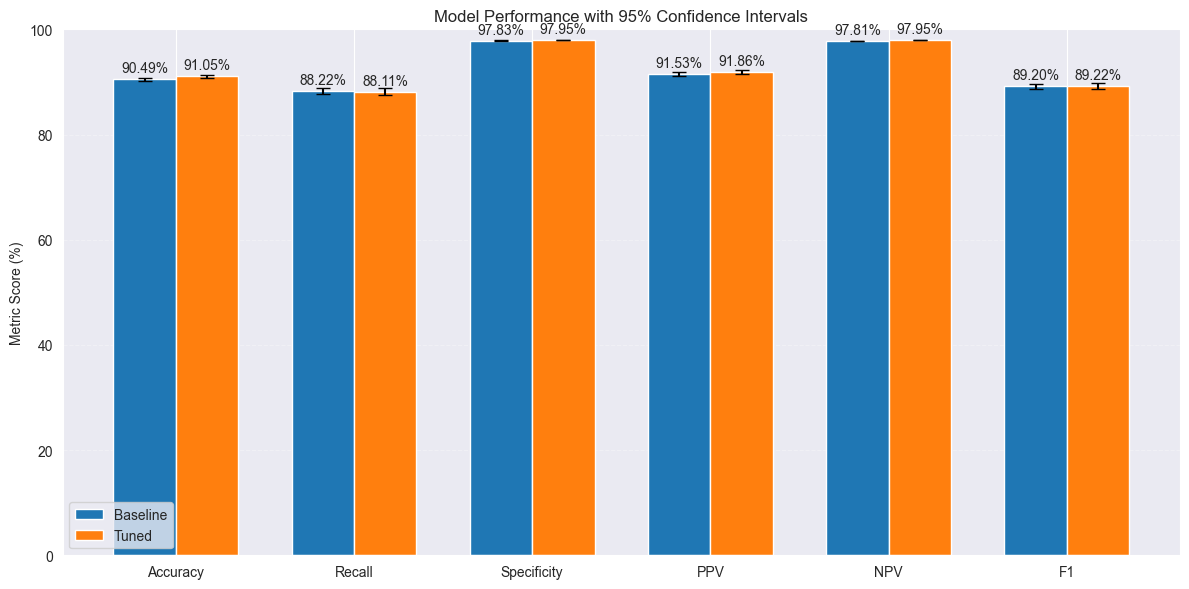

In [ ]:
# Confidence Interval Plot

# Prepare numeric data for plotting
plot_data = pd.DataFrame({
    'Baseline Mean': [baseline_ci[m]['mean']*100 for m in metrics],
    'Tuned Mean': [tuned_ci[m]['mean']*100 for m in metrics]
}, index=metrics)

# Calculate error bars
err = np.empty((2, len(metrics), 2))  # 2(lower/upper) × metrics × models
for i, metric in enumerate(metrics):
    # Baseline errors
    err[0,i,0] = plot_data.loc[metric, 'Baseline Mean'] - baseline_ci[metric]['lower']*100
    err[1,i,0] = baseline_ci[metric]['upper']*100 - plot_data.loc[metric, 'Baseline Mean']
    # Tuned errors
    err[0,i,1] = plot_data.loc[metric, 'Tuned Mean'] - tuned_ci[metric]['lower']*100
    err[1,i,1] = tuned_ci[metric]['upper']*100 - plot_data.loc[metric, 'Tuned Mean']

# Create plot
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(metrics))
width = 0.35

# Plot bars
baseline_bars = ax.bar(x - width/2, plot_data['Baseline Mean'], width,
                      yerr=err[:,:,0], capsize=5, label='Baseline')
tuned_bars = ax.bar(x + width/2, plot_data['Tuned Mean'], width,
                   yerr=err[:,:,1], capsize=5, label='Tuned')

# Customize plot
ax.set_ylabel('Metric Score (%)')
ax.set_title('Model Performance with 95% Confidence Intervals - XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim(0, 100)

# Add value labels
for bars in [baseline_bars, tuned_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords="offset points",
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

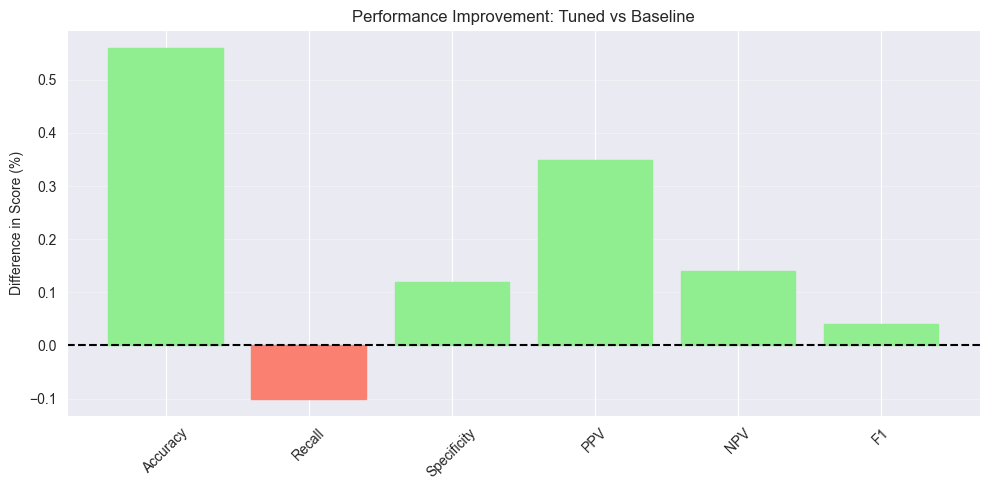

In [ ]:
# Performance Difference Plot

# Calculate differences
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

# Create difference plot
plt.figure(figsize=(10,5))
bars = plt.bar(metrics, diff, color='skyblue')
plt.axhline(0, color='black', linestyle='--')

# Highlight improvements
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('lightgreen')
    else:
        bar.set_color('salmon')

plt.title("Performance Improvement: Tuned vs Baseline - XGBoost")
plt.ylabel("Difference in Score (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Get predictions from both models
baseline_preds = baseline_model[0].predict(X_kot_aligned) if isinstance(baseline_model, tuple) else baseline_model.predict(X_kot_aligned)
tuned_preds = tuned_model[0].predict(X_kot_aligned) if isinstance(tuned_model, tuple) else tuned_model.predict(X_kot_aligned)

# Calculate agreement percentage
agreement = np.mean(baseline_preds == tuned_preds) * 100

# Print results
print(f"Model Prediction Agreement: {agreement:.2f}%")

Model Prediction Agreement: 96.55%


# Interpretation - SHAP

In [ ]:
import shap

# Prepare background data for SHAP explainer
background_data = tuned_model.named_steps["scaler"].transform(X_kot_aligned.sample(100, random_state=42))

# Get the XGBoost model from the pipeline
xgb_model = tuned_model.named_steps["model"]

# Create SHAP explainer for the tuned model
explainer = shap.Explainer(xgb_model, background_data)

# Compute SHAP values for the (scaled) test set
X_kot_scaled = tuned_model.named_steps["scaler"].transform(X_kot_aligned)
shap_values = explainer(X_kot_scaled)

 42%|========            | 122349/293676 [05:17<07:23]       

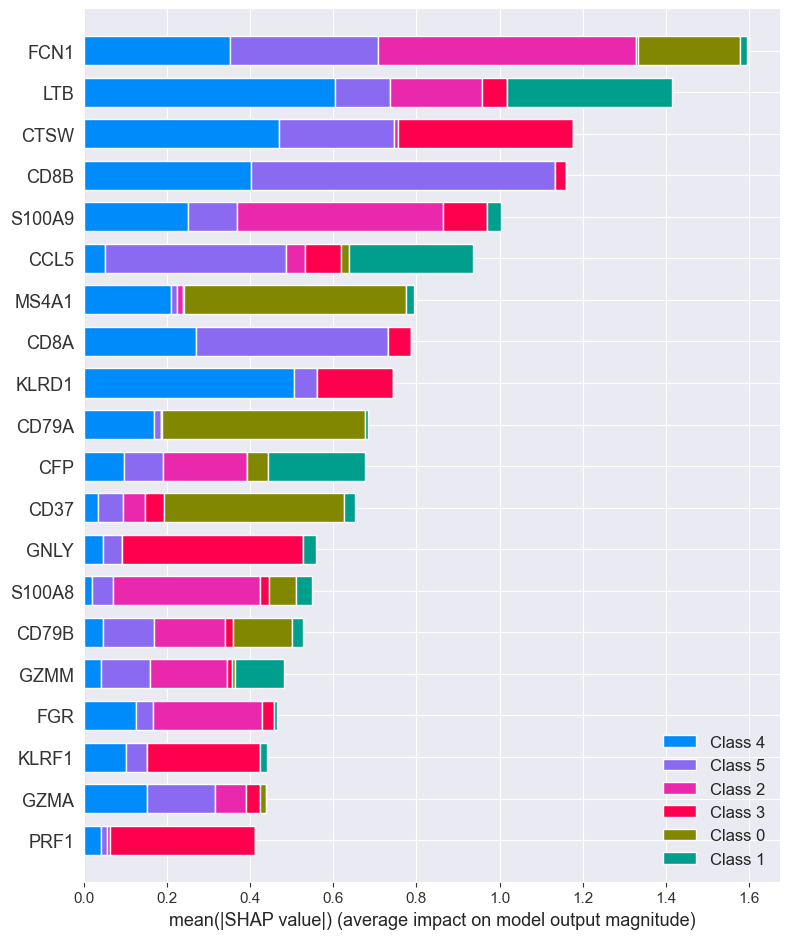

In [ ]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_kot_aligned, feature_names=expected_features, max_display=20, plot_type="bar")

---
---